# Video object detection

## Import the libraries and models

In [1]:
!pip install Pillow
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install youtube_dl==2020.12.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import cv2 
import skimage
import numpy as np
from PIL import Image
import time
import youtube_dl
import matplotlib.pyplot as plt
from transformers.image_utils import ImageFeatureExtractionMixin
from tqdm import tqdm

Download the object detection model

In [5]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import torch

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Download the similarity model

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from transformers import AutoImageProcessor, DPTModel
from sklearn.metrics.pairwise import cosine_similarity

Define the constants to perform the detection

In [8]:
VIDEO_URL = 'https://www.youtube.com/watch?v=NsRLOV4pHyk&t'
RESOLUTION = '360p'
TEXT_QUERIES = ['Image of a black t-shirt'] # Text query used to detect the object, should start with 'image of' or 'photo of'
SCORE_THRESHOLD = 0.15 # Threshold for confidence of the detected objects. For most objects it works fine in the 0.10-0.15 range.
SIM_THRESHOLD = 0.15 # Threshold on the similarity between the detected object and the template object
SAMPLING_RATE = 5 # It is used to define the number of frames to skip between one computation to the next one. frame_to_skip = video_fps / sampling_rate
TEMPLATE_PATH = 'template1.jpg' # Path to the template object
TITLE = 'ironman_vs_loki'
RUN_TEMPL_COMP = False # Boolean that decides whether to include the template comparison or not

In [9]:
# Load the models
image_processor = AutoImageProcessor.from_pretrained("Intel/dpt-large")
similarity_model = DPTModel.from_pretrained("Intel/dpt-large")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at Intel/dpt-large were not used when initializing DPTModel: ['head.head.4.weight', 'neck.fusion_stage.layers.2.residual_layer1.convolution2.bias', 'neck.reassemble_stage.layers.3.projection.bias', 'neck.fusion_stage.layers.2.residual_layer2.convolution1.bias', 'neck.fusion_stage.layers.0.projection.weight', 'head.head.0.weight', 'neck.reassemble_stage.layers.3.resize.bias', 'neck.reassemble_stage.readout_projects.1.0.weight', 'neck.fusion_stage.layers.1.residual_layer2.convolution2.bias', 'neck.fusion_stage.layers.1.residual_layer1.convolution2.bias', 'head.head.2.bias', 'neck.fusion_stage.layers.3.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.1.residual_layer2.convolution1.weight', 'neck.reassemble_stage.readout_projects.1.0.bias', 'neck.reassemble_stage.layers.0

In [10]:
def get_image_encoding(image):
  # Process the input image
  inputs = image_processor(image, return_tensors="pt")

  with torch.no_grad():
      outputs = similarity_model(**inputs)

  # Get the ouput of the pooling layer
  image_encoding = outputs.pooler_output

  return image_encoding

def get_image(path):
  image = Image.open(path) 
  image = image.convert('RGB')
  return image

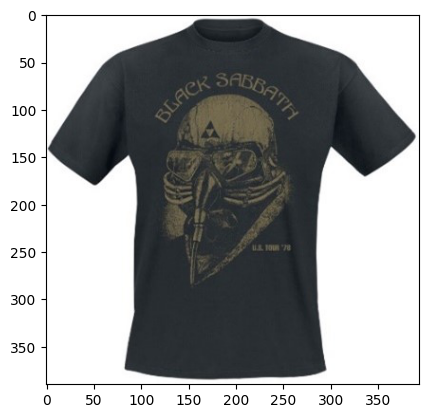

In [11]:
# Get the encoding of the reference image
reference_image = get_image(TEMPLATE_PATH)
reference_encoding = get_image_encoding(reference_image)

plt.imshow(reference_image)

## Get bounding boxes from video

In [12]:
def adjust_frame(frame, patch_size):
    def reduce_size_black_rows(frame, patch_size, upper_limit, lower_limit):
        """
        Performs in-place reduction of the size of the black rows
        """
        zeros_row = np.zeros(frame.shape[1:]).astype(int)
        indices = np.array([i for i in range(frame.shape[0]) if (frame[i,:,:] == zeros_row).all()])
        if len(indices) > 0:
            upper_indices = indices[indices <= lower_limit]
            lower_indices = indices[indices >= upper_limit]
            #print(f'The shape of the frame is {frame.shape}')
            #print(f'The shape of upper_indices is {upper_indices.shape}')
            #print(f'The shape of lower_indices is {lower_indices.shape}')
            # a border = patch_size/2 is left at the top and the bottom of the frame
            if upper_indices.shape[0] > 0:
                min_row_idx = max([upper_indices[len(upper_indices)-1] - int(patch_size/2),0])
            else:
                min_row_idx = 0
            if lower_indices.shape[0] > 0:
                max_row_idx = min([lower_indices[0] + int(patch_size/2),frame.shape[0]])
            else:
                max_row_idx = frame.shape[0]

            rows_idxs = np.zeros(frame.shape[0]).astype(bool)
            rows_idxs[min_row_idx:max_row_idx+1] = 1

            return frame[rows_idxs,:,:]
        return frame


    def add_black_columns(frame, patch_size):
        """
        Performs in-place black columns concatenation to frame
        """
        n_columns = int(patch_size/2)
        vertical_black_col = np.zeros((frame.shape[0],n_columns,3)).astype(int)
        frame = np.concatenate((frame,vertical_black_col), axis=1)
        frame = np.concatenate((vertical_black_col,frame), axis=1)
        return frame


    #frame = reduce_size_black_rows(frame, patch_size, upper_limit=430, lower_limit=50)
    frame = add_black_columns(frame, patch_size)
    return frame

In [13]:
def detect_on_video_frames(video_url, resolution='480p', frame_per_second=10, patch_size=32, text_queries=None, model=None, score_threshold=0.15, sim_threshold=0.10, run_sim=True):
  """
  Function to detect the specified object in each frame of the video
  @param: video_url is the link to the video to analyse
  @param: resolution is the resolution of the video to acquire
  @param: frame_per_second is the number of frame to analyse in a second
  @param: model is the model that performs object detection
  @param: score_threshold is the threshold to avoid detecting objects with low prob
  @param: sim_threshold is the threshold to compare a detected image to the template
  @param: use_sim boolean to decide whether to include the image comparison or not
  """
  # Get the video
  ydl_opts = {}
  ydl=youtube_dl.YoutubeDL(ydl_opts)
  info_dict=ydl.extract_info(video_url, download=False)

  # Instanciate the lists
  frame_counter = 0
  bb_list = []

  time1 = time.time()

  model = model.to(device)

  # Threshold to eliminate low probability predictions
  score_threshold = score_threshold
  # Threshold to eliminate the product non of interest according to their similarity wrt the reference item
  similarity_threshold = sim_threshold

  # Check the resolution
  list_of_available_resolutions = ['240p', '360p', '480p', '720p']
  if resolution not in list_of_available_resolutions:
    resolution = list_of_available_resolutions[0]

  formats = info_dict.get('formats', None)
  print("Obtaining frames")
  for f_number, f in enumerate(formats):

    # If the resolution is 360p and if the format is webm (faster than mp4)
    if f.get('format_note', None) == resolution and f.get('ext', None) == 'webm' and f.get('filesize', None) != None:
      # Get the url
      url = f.get('url', None)

      # Define how many frames to skip between each analysis
      skip_frames = int(f['fps'] / frame_per_second)

      cap = cv2.VideoCapture(url)
      current_frame = 0
      t0 = time.time()
      # Till the end of the video
      while True:
        print(f'Computing frame number {frame_counter}')
        # Get the frame
        ret, frame = cap.read()

        if not ret:
            print(f'Finished the video')
            break

        # Add columns to the frame to improve the quality of the detections
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = adjust_frame(frame, patch_size)

        # Save the shape of the frame
        frame_dimension = frame.shape

        # If save the frame
        # cv.imwrite(filename, frame)
        # Append the frame and the filename in the lists
        #images_list.append(frame)

        # Process image and text inputs
        inputs = processor(text=text_queries, images=frame, return_tensors="pt").to(device)

        # Get predictions
        with torch.no_grad():
          outputs = model(**inputs)

        frame_boxes = []

        # Get prediction logits
        logits = torch.max(outputs["logits"][0], dim=-1)
        scores = torch.sigmoid(logits.values).cpu().detach().numpy()

        # Get prediction labels and boundary boxes
        labels = logits.indices.cpu().detach().numpy()
        boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

        for score, box, label in zip(scores, boxes, labels):
            # If the model isn't sure enough, do not consider the bounding box
            if score < score_threshold:
                continue
            else:
                if run_sim:
                  # Get the detected image coordinates
                  cx, cy, w, h = box
                  # Get the portion of the detected image 
                  bb_image = frame[int(cy*frame.shape[0]-h*frame.shape[0]/2): int(cy*frame.shape[0]+h*frame.shape[0]/2), int(cx*frame.shape[1]-w*frame.shape[1]/2): int(cx*frame.shape[1]+w*frame.shape[1]/2)]
                  # Get the encoding of the image
                  bb_encoding = get_image_encoding(bb_image)
                  # Compute the similarity score
                  sim_score = cosine_similarity(reference_encoding, bb_encoding)[0][0]
                  # If the score is higher than the thershold
                  if sim_score >= similarity_threshold:
                    frame_boxes.append(box)
                else:
                  frame_boxes.append(box)
        
        bb_list.append(frame_boxes)

        # Skip some frames
        current_frame += skip_frames
        cap.set(1, current_frame)
        frame_counter += 1
        #if cv2.waitKey(30) & 0xFF == ord('q'):
         #   break
      #print("Saved {} images with format {} and resolution {} in {:.4} seconds ({:.4} minutes)".format(len(images_list), f.get('ext', None), f.get('format_note',None), (time.time() - t0), (time.time() - t0) / 60 ))
      time2 = time.time()
      print(time2-time1)

      return bb_list

In [14]:
bb_list = detect_on_video_frames(video_url=VIDEO_URL, 
                                 resolution=RESOLUTION, frame_per_second=SAMPLING_RATE, patch_size=32, text_queries=TEXT_QUERIES, 
                                 model=model, score_threshold=SCORE_THRESHOLD, sim_threshold=SIM_THRESHOLD, run_sim=RUN_TEMPL_COMP)

[youtube] NsRLOV4pHyk: Downloading webpage
Obtaining frames
Computing frame number 0
Computing frame number 1
Computing frame number 2
Computing frame number 3
Computing frame number 4
Computing frame number 5
Computing frame number 6
Computing frame number 7
Computing frame number 8
Computing frame number 9
Computing frame number 10
Computing frame number 11
Computing frame number 12
Computing frame number 13
Computing frame number 14
Computing frame number 15
Computing frame number 16
Computing frame number 17
Computing frame number 18
Computing frame number 19
Computing frame number 20
Computing frame number 21
Computing frame number 22
Computing frame number 23
Computing frame number 24
Computing frame number 25
Computing frame number 26
Computing frame number 27
Computing frame number 28
Computing frame number 29
Computing frame number 30
Computing frame number 31
Computing frame number 32
Computing frame number 33
Computing frame number 34
Computing frame number 35
Computing fram

## Build the dictionary

In [15]:
def build_dict(title, sampling_rate, resolution):

  info_dict = {}

  info_dict['title'] = title
  info_dict['sampling_rate'] = sampling_rate
  info_dict['resolution'] = resolution

  # For each frame
  for frame_number in tqdm(range(len(bb_list))):
    # Instanciate the info_dict dictionary for the current frame
    info_dict[frame_number] = {}
    # For each bounding box associated to the current frame
    for bb_index in range(len(bb_list[frame_number])):
      # Get the current bounding box
      bb = bb_list[frame_number][bb_index].tolist()
      # Extract the object image from the frame
      #bb_image = frames[frame_number][bb[1]: bb[1]+bb[3], bb[0]: bb[0]+bb[2]] 
      # If save the sub-image if it is valid
      #if bb_image.shape[0] > 0 and bb_image.shape[1] > 0:
      # Save the details into the dictionary
      info_dict[frame_number][bb_index] = {}
      info_dict[frame_number][bb_index]["Coordinates"] = bb

  return info_dict

In [16]:
info_dict = build_dict(TITLE, SAMPLING_RATE, RESOLUTION)

100%|██████████| 1031/1031 [00:00<00:00, 190440.28it/s]


In [17]:
import json

def write_json(title, info_dict):

  with open(title+'.json', "w") as outfile:
      json.dump(info_dict, outfile, indent=4)

In [18]:
write_json(TITLE, info_dict)